# Non-Negativ Matrix Factorization Model on 1-gram Tokens

In [1]:
import warnings
warnings.simplefilter('ignore')
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
from src.models.nmfTopicModeler import nmfTopicModeler

import pandas as pd
import numpy as np
import seaborn as sns

import pyLDAvis
import pyLDAvis.sklearn

### Load dataset

In [2]:
path_to_data = Path('../data')
df = pd.read_csv(path_to_data / 'processed' /'tokenized1gram_data.csv', converters={'tokenized': eval, 'tokenized_mults': eval, 'tokenized_mults_extr': eval})

### Fit model for cleaned token set (excl. extra stops)

In [3]:
topic_mdl = nmfTopicModeler(n_components = 8, max_iter = 10000)
topic_mdl.fit(df['tokenized_mults_extr'])

pyLDAvis.enable_notebook()
vis_nmf = pyLDAvis.sklearn.prepare(topic_mdl.mdl,\
                                   topic_mdl.doc_term_matrix, topic_mdl.vectors)
vis_nmf

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.032571  0.099083       1        1  15.287240
2      0.045876  0.070496       2        1  14.199424
7      0.094575 -0.077144       3        1  13.668674
0      0.043915  0.012908       4        1  12.657535
6     -0.096280 -0.086007       5        1  11.955627
5      0.134845  0.168193       6        1  11.606024
4     -0.282578  0.018530       7        1  11.347647
1      0.092217 -0.206060       8        1   9.277830, topic_info=            Term       Freq      Total Category  logprob  loglift
654        csekk  47.000000  47.000000  Default  30.0000  30.0000
1877  hozzájárul  26.000000  26.000000  Default  29.0000  29.0000
2924       levél  37.000000  37.000000  Default  28.0000  28.0000
339         bank  21.000000  21.000000  Default  27.0000  27.0000
2150      jelszó  20.000000  20.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
5298      összeg   4.401948  32.520324   Topic8  -5.1741   0.3777
317    azonosító   3.205508  18.799102   Topic8  -5.4913   0.6086
4708        utal   3.454763  28.820346   Topic8  -5.4164   0.2562
47            ad   3.461285  32.749114   Topic8  -5.4145   0.1303
526    biztosító   2.809162  11.338450   Topic8  -5.6233   0.9822

[616 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
2         5  1.404891            157es
12        8  1.952378  2400dunaújváros
47        1  0.183211               ad
47        2  0.091606               ad
47        3  0.061070               ad
...     ...       ...              ...
5357      6  0.122215           ügyfél
5361      7  0.963261     ügyfélprofil
5362      2  0.323222  ügyfélszolgálat
5362      5  0.484832  ügyfélszolgálat
5369      7  1.030315           ügynök

[967 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 8, 1, 7, 6, 5, 2])

#### Show topic key words

In [4]:
topic_mdl.show_topics(8)

['tud szerződés név információ meghatalmazás ért telefon biztosítás',
 'bank csoportos megbízás levon von beszedési levonás terhelés',
 'díj évforduló éves biztosítás szerződés fizet következő negyedéves',
 'levél kap küld biztosítás email hátralék néz cím',
 'hozzájárul ajánlat adat elérhetőség akció megkeres szerződés álló',
 'csekk befizet fizet küld kap negyedév tud negyedéves',
 'jelszó tud cím email felület online felhasználónév regisztráció',
 'utal összeg közlemény lát számlaszám pénz utalás ír']

* 0 - adatvédelmi okokból csak a szerződőnek info 
* 1 - csoportos beszedés nem működött  
* 2 - évfordulóval kapcsolatos díjváltozást nem érti
* 3 - levél vagy email a hátralékról (inter, díjfelszólító)
* 4 - marketing hozzájárulás
* 5 - csekkes befizetés probléma
* 6 - online irányba terelés
* 7 - egyedi utalásos probléma

#### Show main topic distribution

In [5]:
# Drop administrative topics 
topic_mdl.drop_topics(drop_list = [0,4,6])

Dropped topics 0,4,6


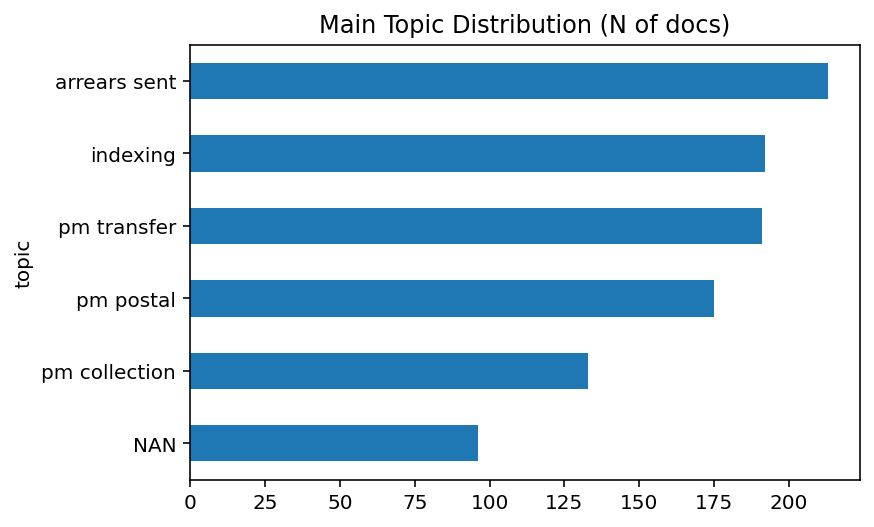

In [101]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

doc_main_topic, main_topic = topic_mdl.get_main_topic(topic_names = ['pm collection', 'indexing', 'arrears sent', 'pm postal', 'pm transfer', 'NAN'],\
                                    threshold = 0.025)
main_topic['count'][::-1].plot.barh(title = 'Main Topic Distribution (N of docs)');

#### Show topic frequency

In [7]:
topic_mdl.get_topic_frequency(topic_names =\
['pm collection', 'annual', 'arrears sent', 'pm postal', 'pm direct'],\
                              threshold = 0.015)

,count,pct
arrears sent,518,0.257840
annual,486,0.241911
pm direct,414,0.206073
pm postal,355,0.176705
pm collection,236,0.117471


#### Show multi-topic distribution

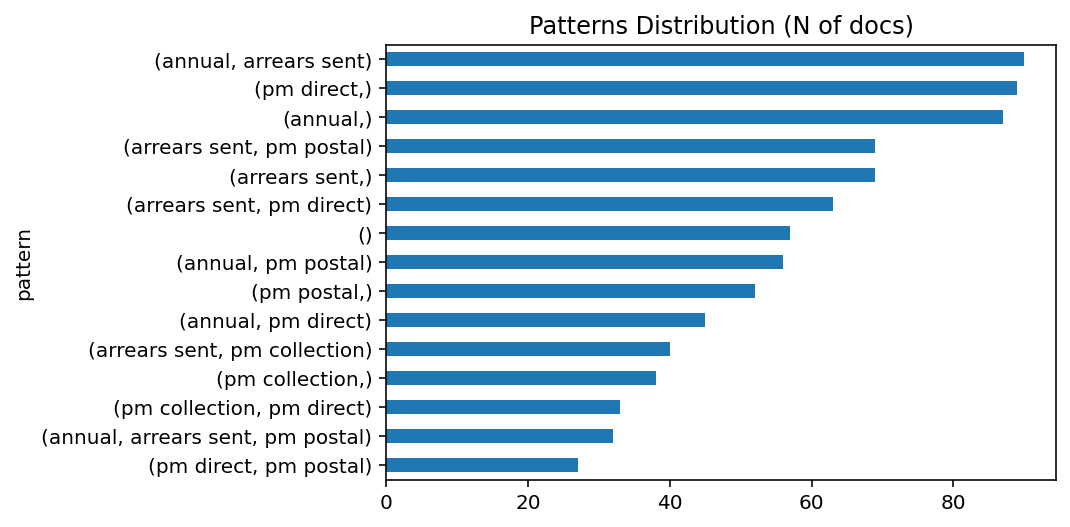

In [72]:
doc_pattern, topic_patterns = topic_mdl.get_topic_patterns(topic_names = ['pm collection', 'annual', 'arrears sent', 'pm postal', 'pm direct'],\
                                    threshold = 0.02)

topic_patterns = topic_patterns.iloc[0:15, 0][::-1]
topic_patterns.plot.barh(title = 'Patterns Distribution (N of docs)');

In [9]:
df_pattern = df.join(pattern_by_doc)
df_pattern.loc[:, ['file_name', 'text', 'pattern']].to_csv(path_to_data / 'processed' / '1gram_pattern_inspect.csv')

NameError: name 'pattern_by_doc' is not defined

### Fit model for main topic and first N of tokens

In [148]:
s = doc_pattern.groupby('topic').size().sort_values(ascending = False).nlargest(5).index
s
doc_pattern[doc_pattern.topic.isin(doc_pattern.groupby('topic').size().sort_values(ascending = False).nlargest(5).index)]

,topic
0,"(annual,)"
5,"(pm direct,)"
8,"(annual,)"
16,"(annual, arrears sent)"
19,"(arrears sent,)"
...,...
987,"(arrears sent,)"
989,"(annual, arrears sent)"
993,"(annual, arrears sent)"
995,"(annual, arrears sent)"


In [149]:
def fit_submodels(tokens, topics, topn_topics=None, n_subtokens=10, n_subtopics=5, n_subwords=8, threshold=0.01):
    # Get first n tokens
    tokens_c = pd.DataFrame(tokens)
    topic_c = topics.copy()
    tokens_c.columns = ['tokens']
    topic_c.columns = ['topic']
    doc_topic = tokens_c.join(topic_c)
    
    # Filter for topn topics
    if topn_topics:
        doc_topic = doc_topic[doc_topic.topic.isin(doc_topic.groupby('topic').size()\
                                    .sort_values(ascending = False).nlargest(topn_topics).index)]
    
    # Get subtokens
    doc_topic['tokens_sub'] = doc_topic['tokens']\
        .apply(lambda doc: [(k, v)[1] for (k, v) in enumerate(doc) if k < n_subtokens])
   
    # Fit models for main topics
    submodels = {}
    for topic in doc_topic['topic'].unique():
        sub = doc_topic.loc[doc_topic['topic'] == topic, :]
        topic_mdl_sub = nmfTopicModeler(n_components = n_subtopics, max_iter = 1000)
        topic_mdl_sub.fit(sub['tokens_sub'])
        submodels[topic] = topic_mdl_sub
        
        _, sub_mains = topic_mdl_sub\
                        .get_main_topic(topic_names = topic_mdl_sub.show_topics(n_subwords)\
                                       , threshold = threshold)
        submodels[topic] = sub_mains
    
    res = pd.concat(submodels.values(), keys=[str(i) for i in submodels.keys()]) 
    return res

subs = fit_submodels(df['tokenized_mults_extr'], doc_pattern, topn_topics=5, n_subtokens=20,\
                     n_subtopics=5, n_subwords=8, threshold = 0.02)

In [150]:
subs

count  \
                              topic                                                       
('annual',)                   ad lakcím születési azonosítás elérhetőség egye...     22   
                              díj éves kérdés fizetés kapcsolat nap szerződés...     20   
                              kötelező autó biztosítás casco fizet gépjármű k...     17   
                              tud segít szerződés szám ad azonosító rendszám ...     17   
                              beszél biztosító munkatárs magyarország keres k...     11   
('pm direct',)                beszél díj megy probléma ügyfél kolléganő bizto...     27   
                              szerződés tud telefonál azonosító segít ügyfél ...     22   
                              születési azonosítás lakcím nap ad dátum név ál...     16   
                              fizet biztosítás tud nap hiba online technikai ...     13   
                              néz pénz szerződés üzenet könyvelv utal szám küld      11   
('annual', 'arrears sent')    lakcím születési ad azonosítás dátum egyeztet e...     22   
                              gépjármű kap ért felelősségbiztosítás értesítés...     20   
                              tud segít casco szerződés biztosítás kis nap autó      19   
                              díj éves következő levél biztosítási befizet ka...     17   
                              rendszám ad tud szám azonosítás segít kötelező ...     12   
('arrears sent',)             biztosítás nap tud kap levél fizet email autó          27   
                              ad születési lakcím szerződés tud dátum azonosí...     20   
                              felelősségbiztosítás értesítés segítség kötelez...      9   
                              lakásbiztosítás év ab óta sms szerződésszám nin...      8   
                              tájékoztat alkalmas biztosító magyarország időp...      5   
('arrears sent', 'pm postal') tud befizet kap nap lakásbiztosítás értesítés s...     16   
                              biztosítás csekk nap küld kap maradva biztosítá...     15   
                              lakcím születési dátum elérhetőség egyeztet ad ...     14   
                              szerződés ad tud szám segít azonosítás azonosít...     14   
                              fizet kap számla nap felszólítás első nincsen o...     10   

                                                                                       pct  \
                              topic                                                          
('annual',)                   ad lakcím születési azonosítás elérhetőség egye...  0.252874   
                              díj éves kérdés fizetés kapcsolat nap szerződés...  0.229885   
                              kötelező autó biztosítás casco fizet gépjármű k...  0.195402   
                              tud segít szerződés szám ad azonosító rendszám ...  0.195402   
                              beszél biztosító munkatárs magyarország keres k...  0.126437   
('pm direct',)                beszél díj megy probléma ügyfél kolléganő bizto...  0.303371   
                              szerződés tud telefonál azonosító segít ügyfél ...  0.247191   
                              születési azonosítás lakcím nap ad dátum név ál...  0.179775   
                              fizet biztosítás tud nap hiba online technikai ...  0.146067   
                              néz pénz szerződés üzenet könyvelv utal szám küld   0.123596   
('annual', 'arrears sent')    lakcím születési ad azonosítás dátum egyeztet e...  0.244444   
                              gépjármű kap ért felelősségbiztosítás értesítés...  0.222222   
                              tud segít casco szerződés biztosítás kis nap autó   0.211111   
                              díj éves következő levél biztosítási befizet ka...  0.188889   
                              rendszám ad tud szám azonosítás segít kötelező ...  0.133333   
('arrears sent',)         

IndexError: index 6 is out of bounds for axis 0 with size 6

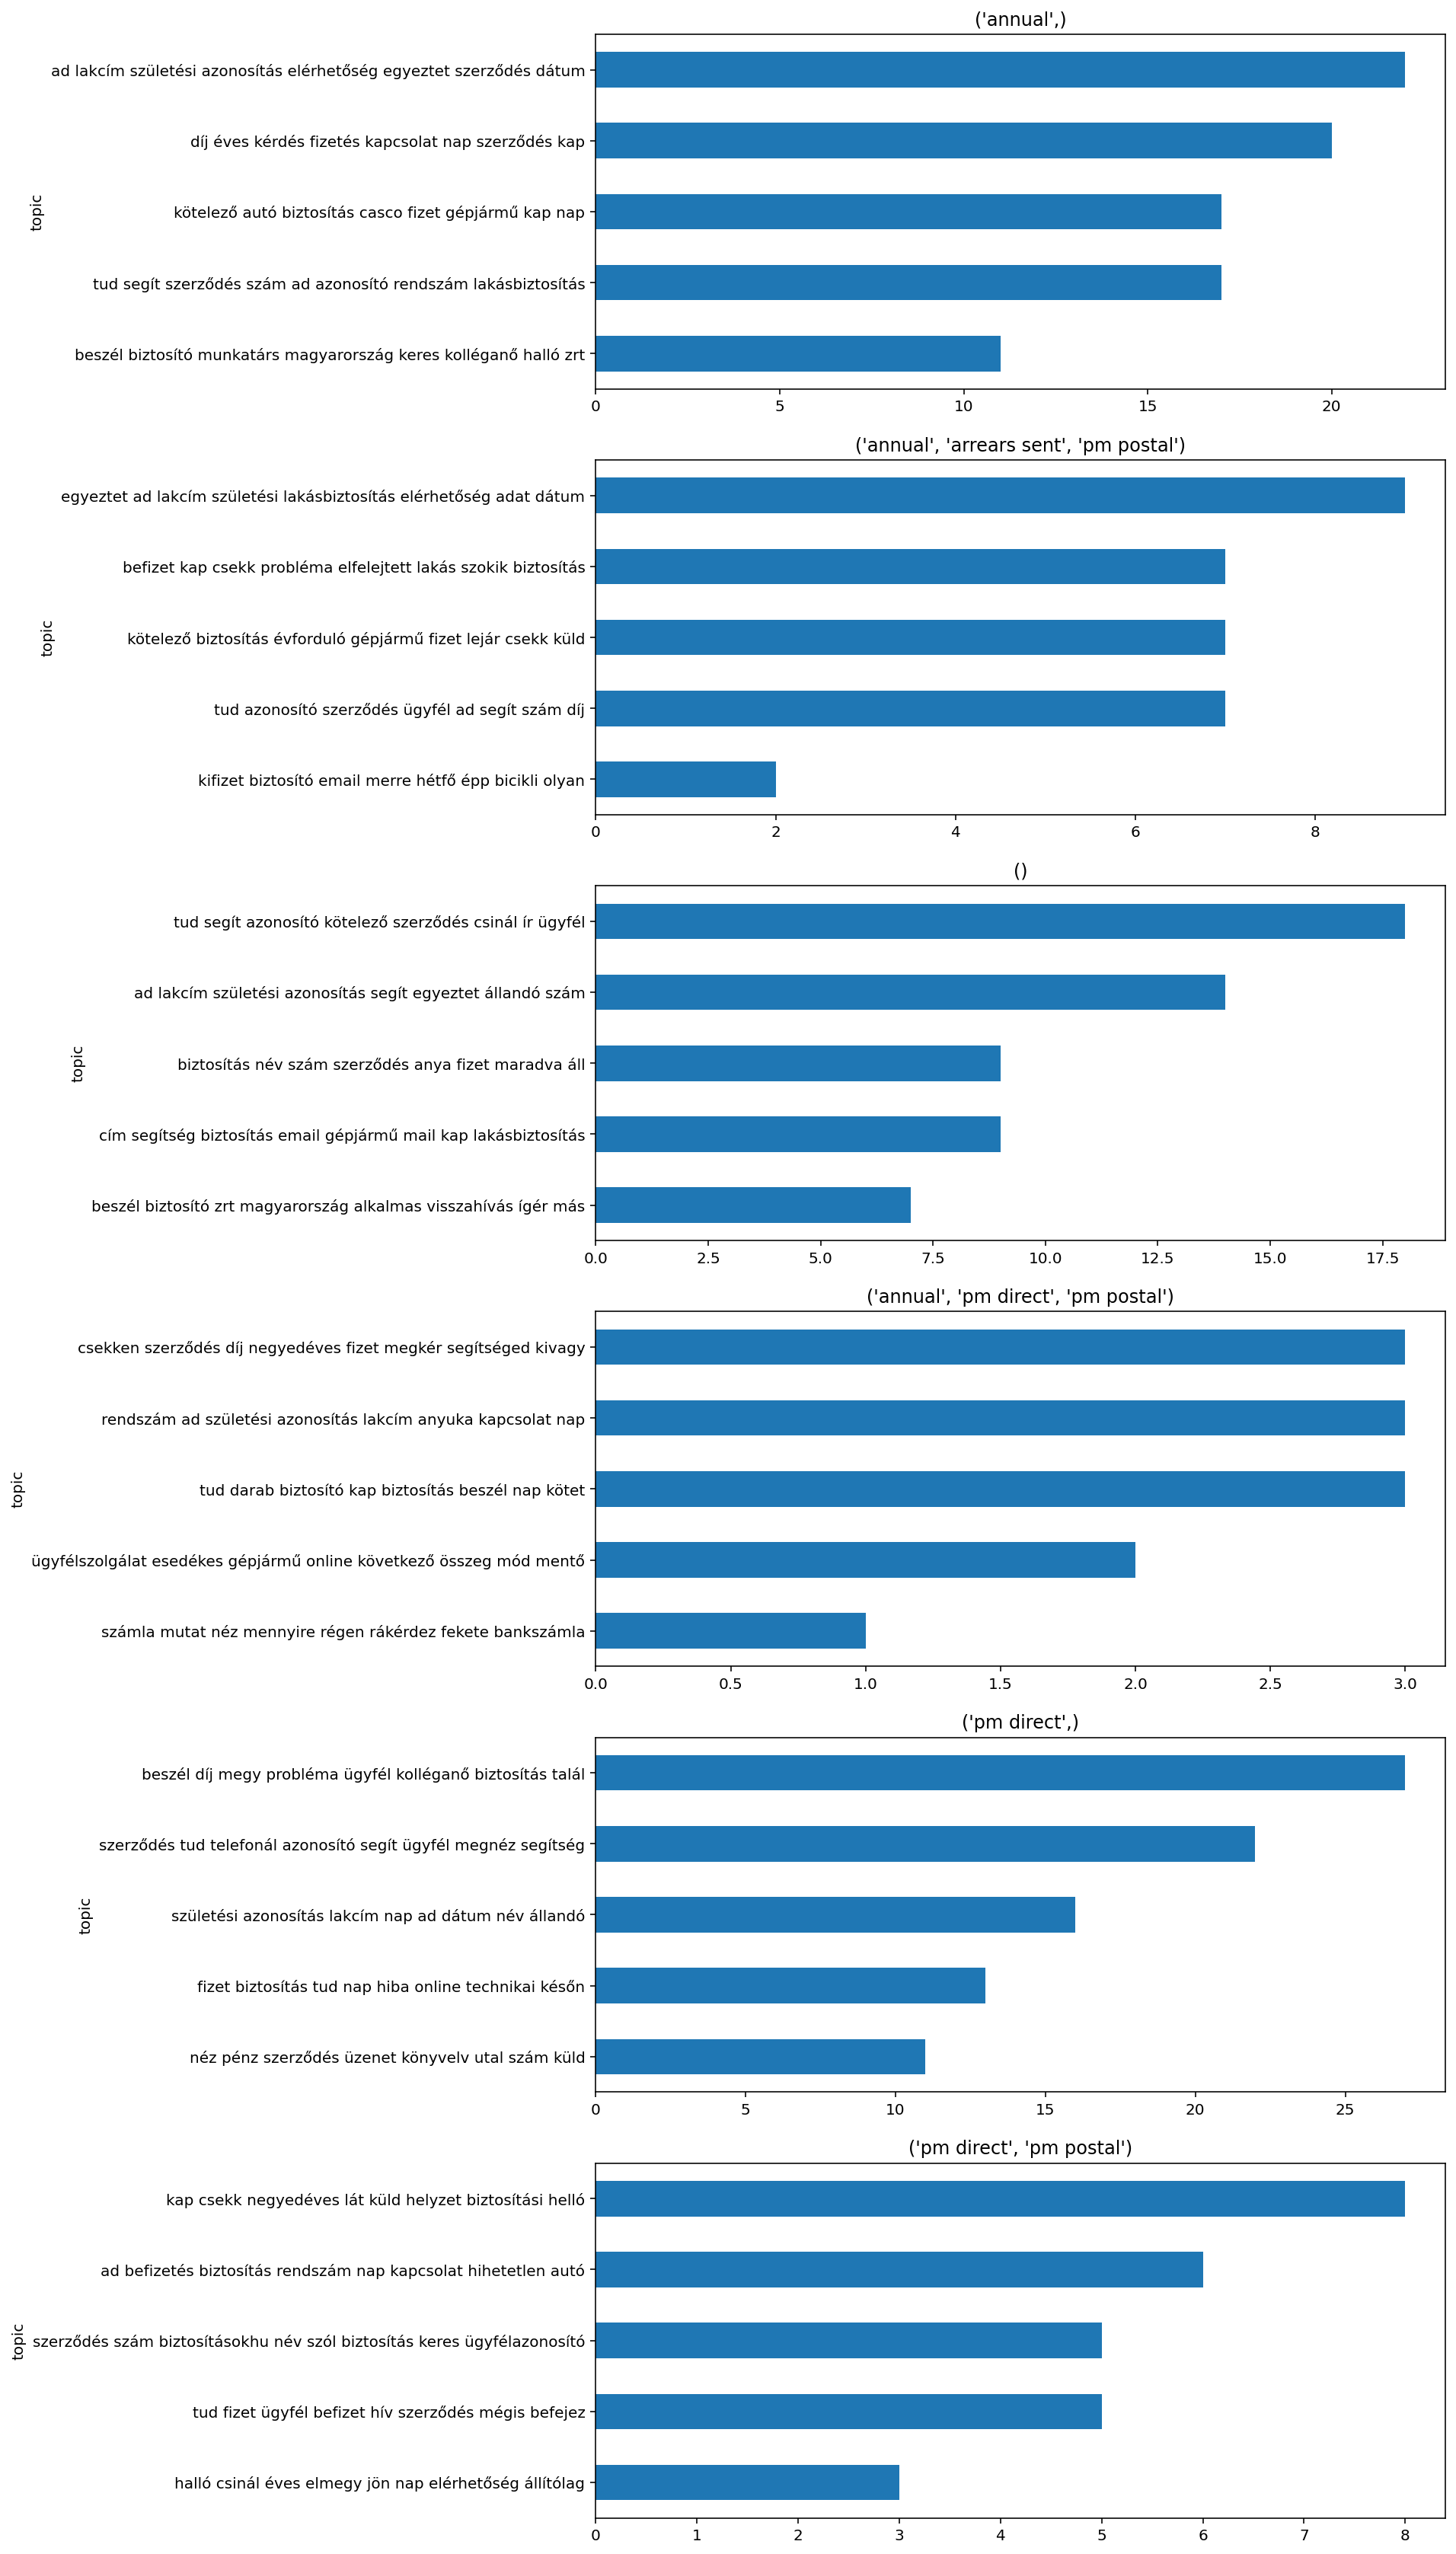

In [66]:
import matplotlib.pyplot as plt
f, a = plt.subplots(6,1, figsize=(10, 30))
for idx, level in enumerate(subs.index.levels[0]):
    subs.loc[level, 'count'][::-1].plot(kind='barh', title = level, ax=a[idx])

In [ ]:
MAIN_TOPIC = 'arrears sent'
NUM_OF_TOPICS = 12
df_subset = df.join(doc_main_topic)
df_subset = df_subset.loc[df_subset['topic'] == MAIN_TOPIC, :]

# Fit NMF
topic_mdl_sub = nmfTopicModeler(n_components = NUM_OF_TOPICS, max_iter = 1000)
topic_mdl_sub.fit(df['tokenized_mults_extr'])

pyLDAvis.enable_notebook()
vis_nmf_subset = pyLDAvis.sklearn.prepare(topic_mdl_sub.mdl,\
                                   topic_mdl_sub.doc_term_matrix, topic_mdl_sub.vectors)
vis_nmf_subset

In [ ]:
topic_mdl_sub.show_topics(8)